## Data preprocessing

### Load libraries

In [69]:
# Librerie base
import numpy as np
import pandas as pd

# Visualizzazione
import matplotlib.pyplot as plt  
import seaborn as sns

# Modelli statistici
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

# Libreria ISLP (Statistical Learning)
from ISLP import load_data
from ISLP.models import (ModelSpec as MS ,summarize, poly)

We will use the Aircraft Price dataset, from Kaggle. 

### Dataset load 

In [70]:
# carico il dataset e stampo l'head
data = pd.read_csv("Data/aircraft_price.csv", encoding='utf-8')
target = 'price'

### data info

In [71]:
data.columns

Index(['model_name', 'engine_type', 'engine_power', 'max_speed',
       'cruise_speed', 'stall_speed', 'fuel_tank', 'all_eng_roc',
       'out_eng_roc', 'takeoff_distance', 'landing_distance', 'empty_weight',
       'length', 'wing_span', 'range', 'price'],
      dtype='object')

In [72]:
print(data.describe())

       engine_power   max_speed  cruise_speed  stall_speed     fuel_tank  \
count    517.000000  517.000000    517.000000   517.000000    517.000000   
mean     869.328820  212.794971    200.177950    60.656673   1419.379110   
std     1783.602771  114.106830    103.358089    16.432874   4278.320773   
min       60.000000   64.000000     70.000000    27.000000     12.000000   
25%      200.000000  143.000000    131.000000    50.000000     50.000000   
50%      285.000000  177.000000    169.000000    56.000000     89.000000   
75%      550.000000  238.000000    229.000000    73.000000    335.000000   
max    14750.000000  755.000000    511.000000   115.000000  41000.000000   

        all_eng_roc  out_eng_roc  takeoff_distance  landing_distance  \
count    517.000000   517.000000        517.000000        517.000000   
mean    1717.558994  2047.065764       1732.750484       7485.489362   
std     1453.489518  1123.433947        713.646967      10289.442474   
min      360.000000   457.0

In [73]:
# Controllo i dati nulli
columnsWithNulls=data.isnull().sum().sort_values(ascending=False)
columnsWithNulls=columnsWithNulls[columnsWithNulls>0]
print(columnsWithNulls)

price    10
dtype: int64


In [74]:
# Controllo in percentuale quanti dati mancano così da capire come trattarli, pongo una soglia di eliminazione del regressore nel caso di +30% di dati mancanti
missing_pct = data.isnull().mean() * 100
missing_only = missing_pct[missing_pct > 0].sort_values(ascending=False)
print(missing_only )

price    1.934236
dtype: float64


In [75]:
#Drop dati nulli
data.dropna(axis=0, inplace=True)
missing_pct = data.isnull().sum()
print("Number of null data: \n")
print(missing_pct)

Number of null data: 

model_name          0
engine_type         0
engine_power        0
max_speed           0
cruise_speed        0
stall_speed         0
fuel_tank           0
all_eng_roc         0
out_eng_roc         0
takeoff_distance    0
landing_distance    0
empty_weight        0
length              0
wing_span           0
range               0
price               0
dtype: int64


### Skewness check

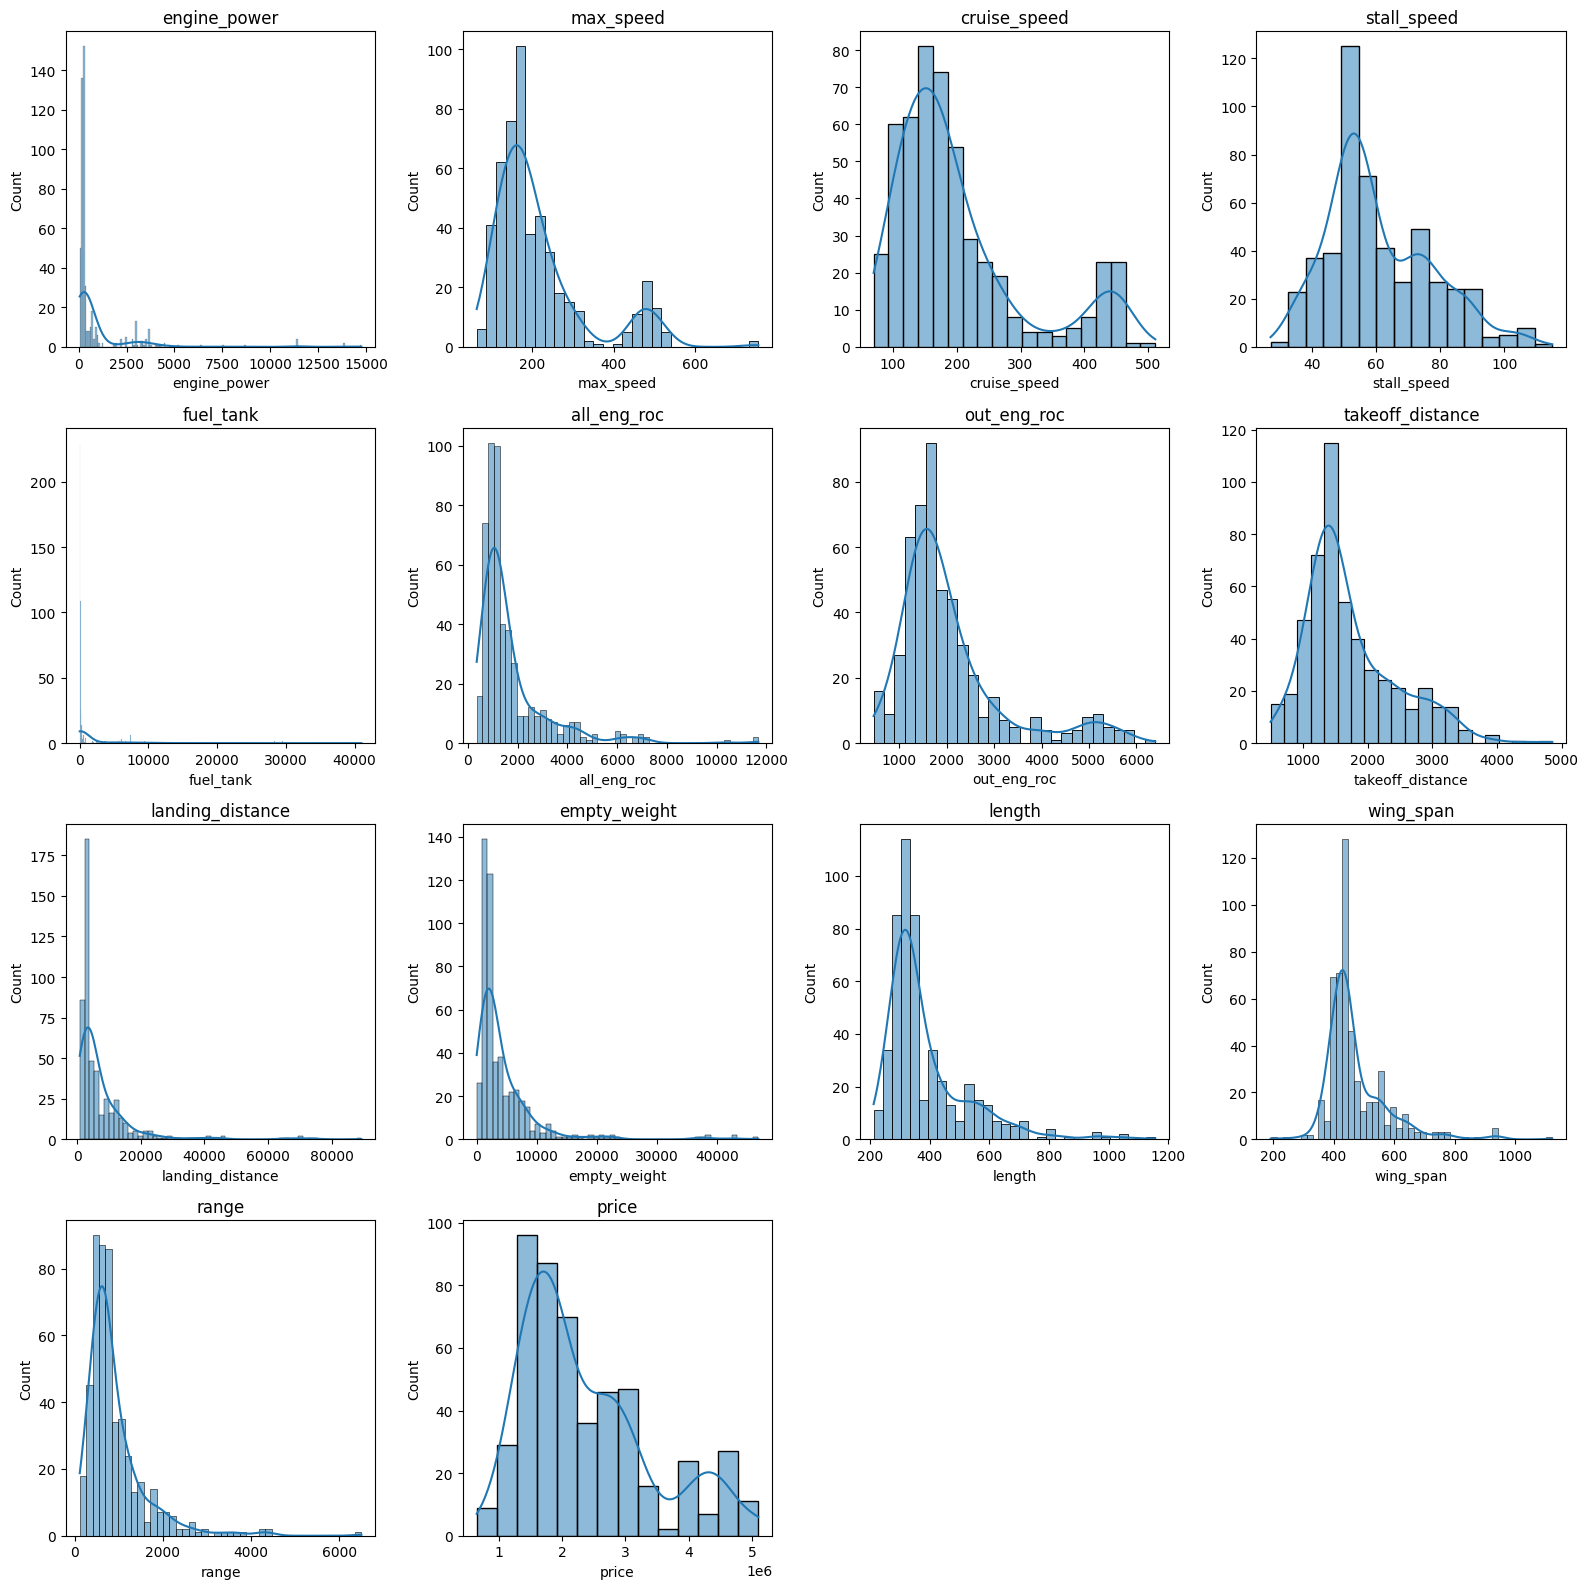

In [76]:
# Plot distributions of all numeric variables
numeric_cols = data.select_dtypes(include=['number']).columns
n = len(numeric_cols)
cols = 4
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
for ax, col in zip(axes.flatten(), numeric_cols):
    sns.histplot(data[col], kde=True, ax=ax)
    ax.set_title(col)

# remove any unused subplots
for ax in axes.flatten()[n:]:
    ax.remove()

plt.tight_layout()
plt.show()

In [77]:
#calcooliamo la skewness
skewness = data[numeric_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
print("Skewness of numeric variables:")
print(skewness)


Skewness of numeric variables:
fuel_tank           5.046265
engine_power        4.690213
landing_distance    4.296546
empty_weight        4.191493
all_eng_roc         3.003339
range               2.945743
wing_span           2.199430
length              2.101332
out_eng_roc         1.746618
max_speed           1.691196
cruise_speed        1.379109
takeoff_distance    1.054754
price               0.949636
stall_speed         0.709297
dtype: float64


In [78]:
# colonne da log-trasformare (skewness > 1)
skewed_feats = [
    'fuel_tank', 'engine_power', 'landing_distance', 'empty_weight',
    'all_eng_roc', 'range', 'wing_span', 'length',
    'out_eng_roc', 'max_speed', 'cruise_speed', 'takeoff_distance'
]

# copia del dataset e applicazione del log(1+x)
logData = data.copy()
for col in skewed_feats:
    logData[col] = np.log1p(logData[col])

# log-trasformartion anche del target:
logData['price'] = np.log1p(logData['price'])

# logData è ora il tuo dataset con le variabili selezionate log-trasformate


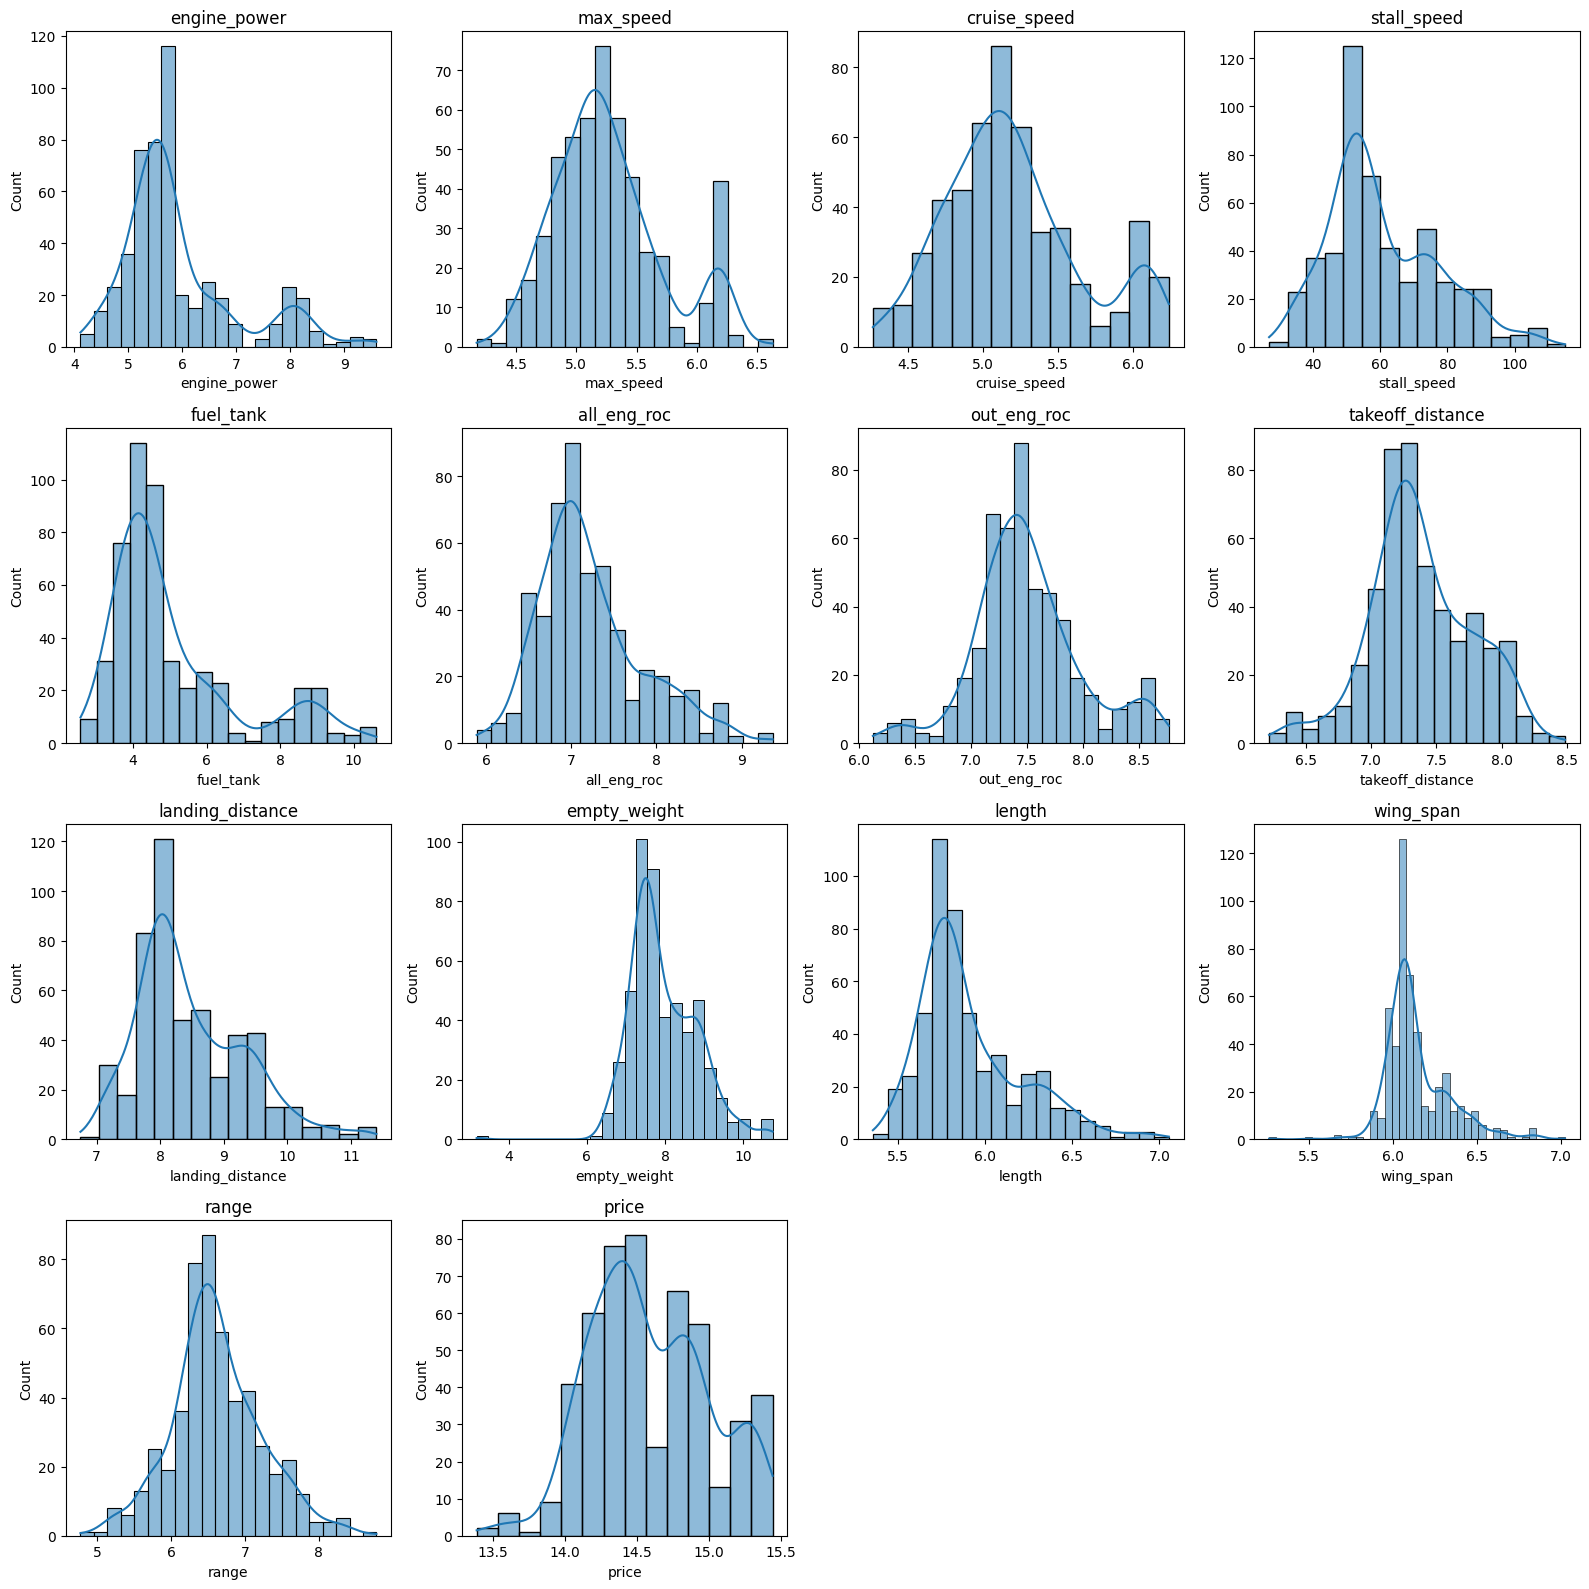

In [79]:
#verifichiamo la skewness
# Plot distributions of all numeric variables
numeric_cols = logData.select_dtypes(include=['number']).columns
n = len(numeric_cols)
cols = 4
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
for ax, col in zip(axes.flatten(), numeric_cols):
    sns.histplot(logData[col], kde=True, ax=ax)
    ax.set_title(col)

# remove any unused subplots
for ax in axes.flatten()[n:]:
    ax.remove()

plt.tight_layout()
plt.show()

## log transformation of target 

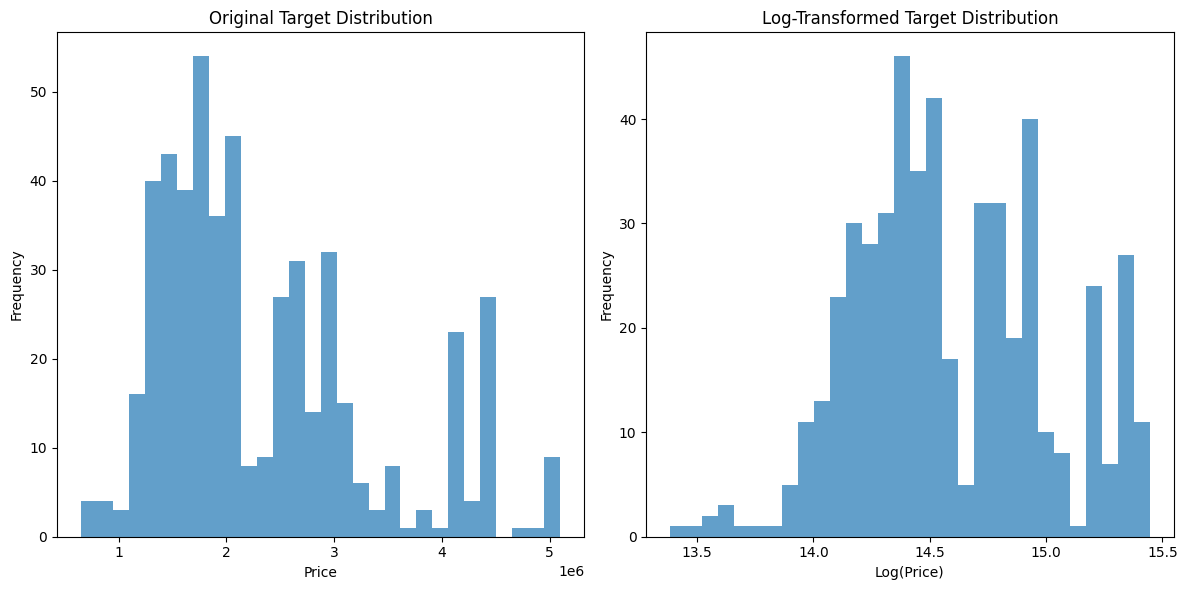

In [80]:
# Log-transform the target variable and compare it with the original target distribution
target = 'price'
log_target = np.log(data[target])

# Plot the original and log-transformed target distributions
plt.figure(figsize=(12, 6))

# Original target distribution
plt.subplot(1, 2, 1)
plt.hist(data[target], bins=30, alpha=0.7)
plt.title('Original Target Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Log-transformed target distribution
plt.subplot(1, 2, 2)
plt.hist(log_target, bins=30, alpha=0.7)
plt.title('Log-Transformed Target Distribution')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


#
- **Distribuzione originale** (istogramma blu): il prezzo è fortemente asimmetrico a destra, con code lunghe fino a 5 M€ e una concentrazione massima attorno a 1–3 M€. Questo livello di skewness può causare problemi di eteroschedasticità e di instabilità nella regressione OLS.  
- **Distribuzione log** (istogramma verde): dopo aver fatto `log(price)`, i valori si raggruppano su una curva molto più simile a una normale — la coda lunga si riduce, e l’intervallo diventa circa 13.5–15.5 sul logaritmo naturale.  

**Cosa ci dice?**  
1. **Assunti di OLS**: il log‐transform aiuta a soddisfare meglio l’ipotesi di normalità dei residui e di varianza costante.  
2. **Linearità percentuale**: un modello lineare su \(\log(price)\) interpreta i coefficienti come variazioni percentuali del prezzo, spesso più sensate di variazioni assolute su una scala ampia.  
3. **Robustezza**: riduci l’influenza degli outlier più estremi, migliorando stabilità e predittività.  


## Correlation matrix

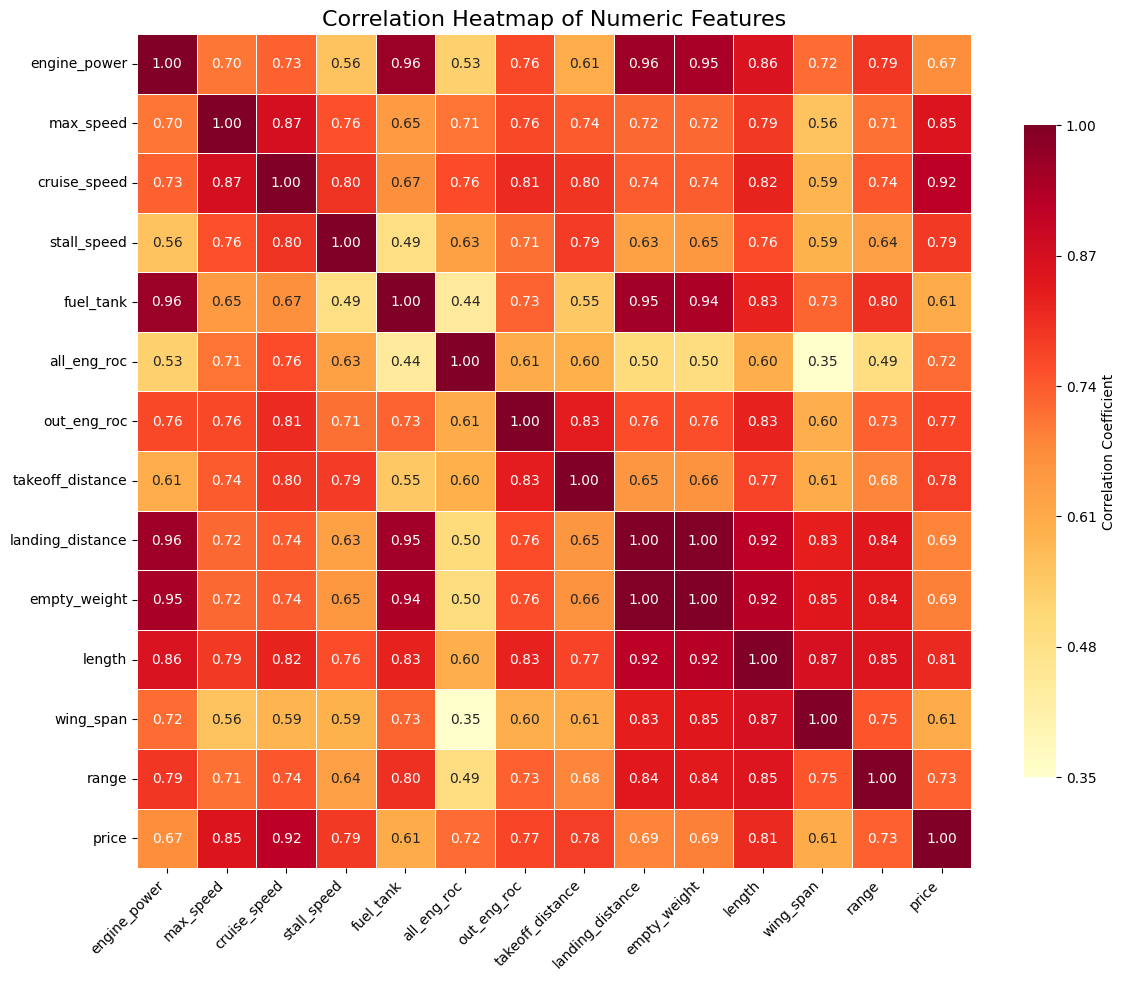

In [81]:
# Seleziona le colonne numeriche
numeric_data = data.select_dtypes(include=[np.number])

if numeric_data.shape[1] >= 4:
    # Calcola la matrice di correlazione
    corr = numeric_data.corr()

    # Escludi la diagonale per calcolare il minimo e massimo reale
    mask = ~np.eye(corr.shape[0], dtype=bool)
    min_corr = round(corr.where(mask).min().min(), 2)
    max_corr = round(corr.where(mask).max().max(), 2)

    # Imposta la figura
    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(
        corr,
        annot=True,
        fmt='.2f',
        cmap='YlOrRd',  # Giallino → Arancione → Rosso scuro
        square=True,
        linewidths=.5,
        vmin=min_corr,
        vmax=max_corr,
        cbar_kws={
            "shrink": .75,
            "label": "Correlation Coefficient",
            "ticks": np.linspace(min_corr, max_corr, 6)  # 6 valori equidistanti
        }
    )

    plt.title('Correlation Heatmap of Numeric Features', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print('Not enough numeric columns for a meaningful correlation heatmap')

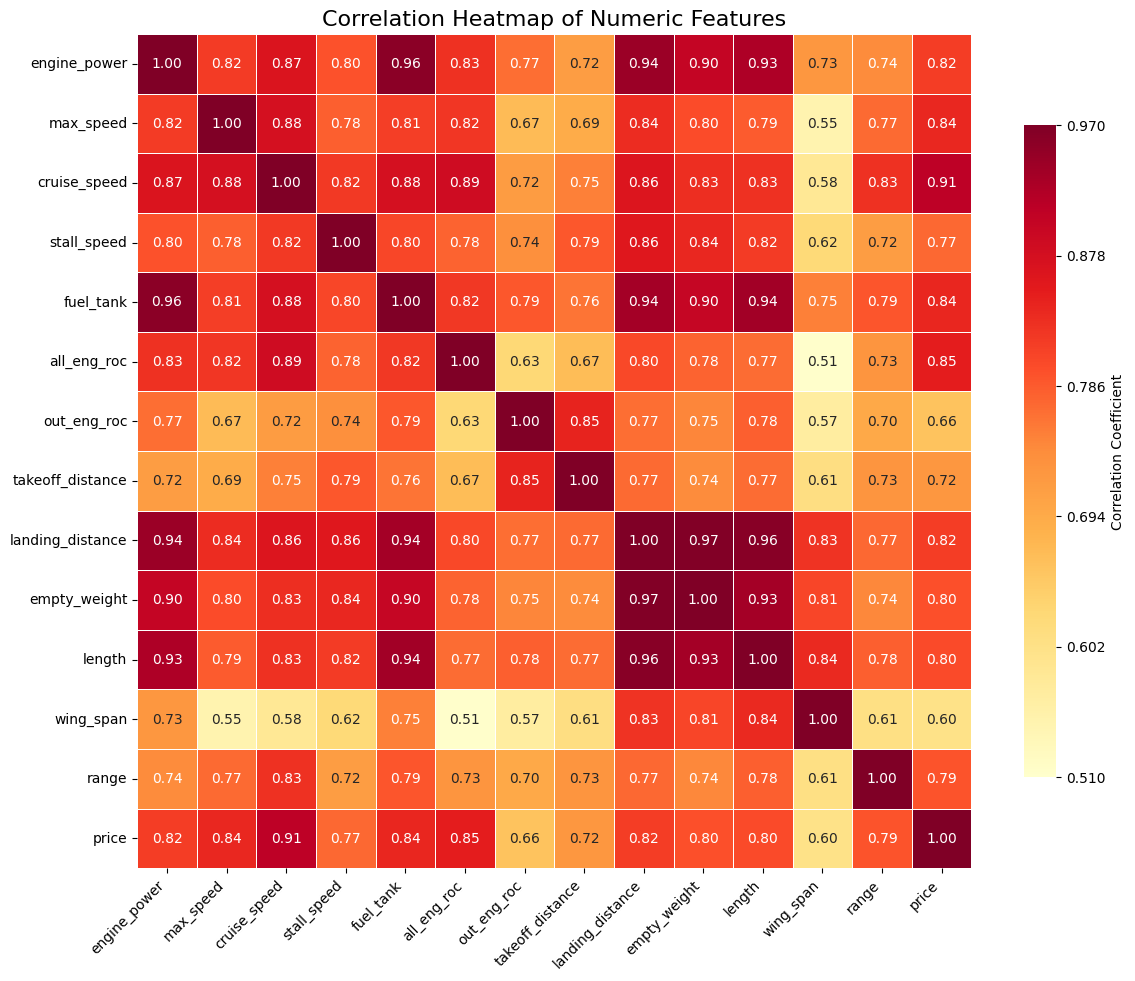

In [ ]:
# Seleziona le colonne numeriche
numeric_data = logData.select_dtypes(include=[np.number])

if numeric_data.shape[1] >= 4:
    # Calcola la matrice di correlazione
    corr = numeric_data.corr()

    # Escludi la diagonale per calcolare il minimo e massimo reale
    mask = ~np.eye(corr.shape[0], dtype=bool)
    min_corr = round(corr.where(mask).min().min(), 2)
    max_corr = round(corr.where(mask).max().max(), 2)

    # Imposta la figura
    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(
        corr,
        annot=True,
        fmt='.2f',
        cmap='YlOrRd',  # Giallino → Arancione → Rosso scuro
        square=True,
        linewidths=.5,
        vmin=min_corr,
        vmax=max_corr,
        cbar_kws={
            "shrink": .75,
            "label": "Correlation Coefficient",
            "ticks": np.linspace(min_corr, max_corr, 6)  # 6 valori equidistanti
        }
    )

    plt.title('Correlation Heatmap of Numeric Features (afer Log-Transformation)', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print('Not enough numeric columns for a meaningful correlation heatmap')

### with log transformation

In [83]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Seleziona le colonne numeriche
numeric_data = logData.select_dtypes(include=[np.number])
# Handle missing or infinite values in the data
numeric_data_cleaned = numeric_data.replace([np.inf, -np.inf], np.nan).dropna()
numeric_data_with_const = sm.add_constant(numeric_data_cleaned)
# Calcola il VIF per ciascuna variabile
vif_data = pd.DataFrame()
vif_data["Regressor"] = numeric_data_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_data_with_const.values, i) for i in range(numeric_data_with_const.shape[1])]
vif_data = vif_data.sort_values("VIF", ascending=False)
print(vif_data)

           Regressor          VIF
0              const  9776.033312
9   landing_distance    54.834620
1       engine_power    21.697669
11            length    19.276523
5          fuel_tank    18.831683
10      empty_weight    17.199763
3       cruise_speed    12.825950
14             price     7.404855
12         wing_span     6.337481
6        all_eng_roc     6.044152
2          max_speed     5.758867
4        stall_speed     5.532121
8   takeoff_distance     5.359086
7        out_eng_roc     5.234937
13             range     4.146934


In [84]:
data.columns

Index(['model_name', 'engine_type', 'engine_power', 'max_speed',
       'cruise_speed', 'stall_speed', 'fuel_tank', 'all_eng_roc',
       'out_eng_roc', 'takeoff_distance', 'landing_distance', 'empty_weight',
       'length', 'wing_span', 'range', 'price'],
      dtype='object')

In [85]:
logData.columns

Index(['model_name', 'engine_type', 'engine_power', 'max_speed',
       'cruise_speed', 'stall_speed', 'fuel_tank', 'all_eng_roc',
       'out_eng_roc', 'takeoff_distance', 'landing_distance', 'empty_weight',
       'length', 'wing_span', 'range', 'price'],
      dtype='object')

### data

In [86]:
#save as csv
data.to_csv("Data/aircraft_price_clean.csv", index=False)
data.columns

Index(['model_name', 'engine_type', 'engine_power', 'max_speed',
       'cruise_speed', 'stall_speed', 'fuel_tank', 'all_eng_roc',
       'out_eng_roc', 'takeoff_distance', 'landing_distance', 'empty_weight',
       'length', 'wing_span', 'range', 'price'],
      dtype='object')

### logData

In [87]:
#save as csv
logData.to_csv("Data/aircraft_price_cleaned_log.csv", index=False)
logData.columns

Index(['model_name', 'engine_type', 'engine_power', 'max_speed',
       'cruise_speed', 'stall_speed', 'fuel_tank', 'all_eng_roc',
       'out_eng_roc', 'takeoff_distance', 'landing_distance', 'empty_weight',
       'length', 'wing_span', 'range', 'price'],
      dtype='object')